In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

IMAGE_SIZE = 200

In [2]:
files = glob.glob('data/images/*.png')
files.sort()

x = []
for f in files:
    img = cv2.imread(f)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    x.append(np.array(img))

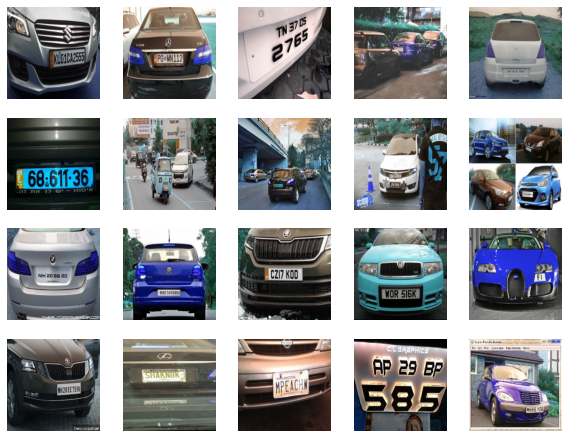

In [3]:
plt.figure(figsize=(10, 20))

for i in range(0, 20) :
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(x[i])

In [4]:
from lxml import etree

def resize_annotation(f):
    tree = etree.parse(f)
    
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
        
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text) / (width / IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text) / (height / IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text) / (width / IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text) / (height / IMAGE_SIZE)
        
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [5]:
annot_files = glob.glob('data/annotations/*.xml')
annot_files.sort()

annot = []
for a_f in annot_files:
    annot.append(resize_annotation(a_f))